# Draft_01_v2

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Authors:** António Cruz (140129), Cátia Brás (), Ricardo Kayseller (95813)

## 1. Environment Setup

---

In [1]:
# Import required dependencies
import os
import numpy as np
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch import Tensor
from torch.nn.utils import spectral_norm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

In [2]:
# Global variables

SEED = 42

LIVE_MONITOR = False
EMIT_INTERVAL = 1

DATASET_PATH = "../../dataset/"

BATCH_SIZE = 128
LATENT_DIM = 100
NUM_CLASSES = 10

NUM_STEPS = 15005
SAVE_INTERVAL = 1000

# Loss function strategy: "bce", "lsgan", "hinge", "wgan-gp"
LOSS_STRATEGY = "wgan-gp"

# TTUR: Two Time-Scale Update Rule
# D learns faster than G, so we use different learning rates
LR_D = 4e-4  # Discriminator learning rate
LR_G = 1e-4  # Generator learning rate (4x slower)

# Adam betas optimized for GAN training
# Lower β1 (0.5 vs default 0.9) reduces momentum, stabilizes adversarial updates
ADAM_BETAS = (0.5, 0.999)

# Label smoothing for BCE/LSGAN (use 0.9 instead of 1.0 for real labels)
LABEL_SMOOTHING_REAL = 0.9

# WGAN-GP: number of critic steps per generator step
N_CRITIC = 5

MODEL_OUTPUT_PATH = "model/"
D_MODEL_NAME = "D_DRAFT_01"
G_MODEL_NAME = "G_DRAFT_01"

NUM_EVAL_SAMPLES = 10000

In [3]:
# Set random seeds for reproducibility across both numpy and pytorch
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Loss Strategies

class GANLossStrategy(ABC):
    """Base class for GAN loss strategies."""
    use_sigmoid: bool = True
    use_label_smoothing: bool = False  # only BCE/LSGAN use this
    n_critic: int = 1  # D steps per G step
    smooth_real: float = 1.0
    
    @abstractmethod
    def d_loss_real(self, output: Tensor) -> Tensor:
        """Discriminator loss for real images."""
        pass
    
    @abstractmethod
    def d_loss_fake(self, output: Tensor) -> Tensor:
        """Discriminator loss for fake images."""
        pass
    
    @abstractmethod
    def g_loss(self, output: Tensor) -> Tensor:
        """Generator loss."""
        pass
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        """Gradient penalty (only used by WGAN-GP)."""
        return torch.tensor(0.0, device=real_imgs.device)
    
    def set_d_model(self, d_model) -> None:
        """Set discriminator reference (used by WGAN-GP)."""
        pass
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """Combine D losses. Override for strategy-specific formulas."""
        return 0.5 * (d_loss_real + d_loss_fake) + gp


class BCELossStrategy(GANLossStrategy):
    """Binary Cross-Entropy loss (original GAN) with label smoothing."""
    use_sigmoid = True
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.BCELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        # G wants D to output 1.0 (no smoothing for G)
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class LSGANLossStrategy(GANLossStrategy):
    """Least Squares loss with label smoothing."""
    use_sigmoid = False
    use_label_smoothing = True
    
    def __init__(self, device, smooth_real: float = 0.9):
        self.device = device
        self.criterion = nn.MSELoss()
        self.smooth_real = smooth_real
        self._real_labels = None
        self._fake_labels = None
    
    def _ensure_labels(self, batch_size):
        if self._real_labels is None or self._real_labels.size(0) != batch_size:
            self._real_labels = torch.full((batch_size, 1), self.smooth_real, device=self.device)
            self._fake_labels = torch.zeros(batch_size, 1, device=self.device)
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._real_labels)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        self._ensure_labels(output.size(0))
        return self.criterion(output, self._fake_labels)
    
    def g_loss(self, output: Tensor) -> Tensor:
        ones = torch.ones(output.size(0), 1, device=self.device)
        return self.criterion(output, ones)


class HingeLossStrategy(GANLossStrategy):
    """Hinge loss — used in SAGAN, BigGAN."""
    use_sigmoid = False
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 - output))
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(F.relu(1.0 + output))
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)


class WGANGPLossStrategy(GANLossStrategy):
    """Wasserstein loss with gradient penalty."""
    use_sigmoid = False
    n_critic = 5  # train D 5 times per G step
    
    def __init__(self, lambda_gp: float = 10.0):
        self.d_model = None
        self.lambda_gp = lambda_gp
    
    def set_d_model(self, d_model) -> None:
        self.d_model = d_model
    
    def d_loss_real(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def d_loss_fake(self, output: Tensor) -> Tensor:
        return torch.mean(output)
    
    def g_loss(self, output: Tensor) -> Tensor:
        return -torch.mean(output)
    
    def gradient_penalty(self, real_imgs: Tensor, fake_imgs: Tensor, labels: Tensor) -> Tensor:
        if self.d_model is None:
            raise RuntimeError("d_model not set. Call set_d_model() first.")
        
        batch_size = real_imgs.size(0)
        
        alpha = torch.rand(batch_size, 1, 1, 1, device=real_imgs.device)
        interpolated = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        
        d_out = self.d_model(interpolated, labels)
        
        gradients = torch.autograd.grad(
            outputs=d_out,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_out),
            create_graph=True,
            retain_graph=True,
        )[0]
        
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        
        return self.lambda_gp * ((gradient_norm - 1) ** 2).mean()
    
    def compute_d_loss(self, d_loss_real: Tensor, d_loss_fake: Tensor, gp: Tensor) -> Tensor:
        """WGAN-GP uses d_fake - d_real + gp (no 0.5 averaging)."""
        return d_loss_fake + d_loss_real + gp  # note: d_loss_real is already negated


def get_loss_strategy(name: str, device) -> GANLossStrategy:
    """Factory function to get loss strategy by name."""
    strategies = {
        "bce": BCELossStrategy,
        "lsgan": LSGANLossStrategy,
        "hinge": HingeLossStrategy,
        "wgan-gp": WGANGPLossStrategy,
    }
    if name not in strategies:
        raise ValueError(f"Unknown loss strategy: {name}. Options: {list(strategies.keys())}")
    
    if name == "bce":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    if name == "lsgan":
        return strategies[name](device, smooth_real=LABEL_SMOOTHING_REAL)
    return strategies[name]()

## 2. Data Loading

---

In [6]:
# Transform: convert PIL image to tensor (scales [0,255] to [0,1]),
# then normalize to [-1, 1] range using mean=0.5, std=0.5
# Formula: (x - 0.5) / 0.5 = 2x - 1, which maps [0,1] to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset from a local folder
train_dataset = datasets.MNIST(
    root=DATASET_PATH,
    train=True,
    download=False,
    transform=transform
)

# DataLoader handles batching, shuffling, and parallel loading
# drop_last=True discards the final incomplete batch so every batch has exactly BATCH_SIZE samples
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Training samples: 60000
Batches per epoch: 468


## 3. Generator

---

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
        )

        # Block 1: 7x7 -> 14x14
        self.conv1 = nn.Conv2d(128, 128 * 4, kernel_size=3, padding=1)
        self.ps1 = nn.PixelShuffle(2)
        self.bn1 = nn.BatchNorm2d(128, momentum=0.8)

        # Block 2: 14x14 -> 28x28
        self.conv2 = nn.Conv2d(128, 64 * 4, kernel_size=3, padding=1)
        self.ps2 = nn.PixelShuffle(2)
        self.bn2 = nn.BatchNorm2d(64, momentum=0.8)

        self.output_conv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.apply(self._init_weights)
        self._icnr_init(self.conv1, upscale_factor=2)
        self._icnr_init(self.conv2, upscale_factor=2)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def _icnr_init(self, conv_layer, upscale_factor):
        """Specialized initialization to prevent checkerboard/dots."""
        new_shape = [
            conv_layer.out_channels // (upscale_factor**2),
            conv_layer.in_channels,
            conv_layer.kernel_size[0],
            conv_layer.kernel_size[1]
        ]
        sub_kernel = torch.randn(new_shape) * 0.02
        # Repeat the sub-kernel across the 'sub-pixel' channels
        # This makes all 4 pixels in a 2x2 block start identical
        icnr_kernel = sub_kernel.repeat_interleave(upscale_factor**2, dim=0)
        conv_layer.weight.data.copy_(icnr_kernel)

    def forward(self, z, labels):
        label_embed = self.label_embedding(labels).squeeze(1)
        x = self.fc(z * label_embed)
        x = x.view(-1, 128, 7, 7)

        x = F.relu(self.bn1(self.ps1(self.conv1(x))))
        x = F.relu(self.bn2(self.ps2(self.conv2(x))))
        return torch.tanh(self.output_conv(x))


# Instantiate and move to device
g_model = Generator().to(device)
print(g_model)

Generator(
  (label_embedding): Embedding(10, 100)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): ReLU()
  )
  (conv1): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps1): PixelShuffle(upscale_factor=2)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ps2): PixelShuffle(upscale_factor=2)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (output_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## 4. Discriminator

---

In [8]:
class Discriminator(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES, use_sigmoid=True):
        super().__init__()
        
        self.use_sigmoid = use_sigmoid

        # Embed the class label into a vector of size 28*28
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)

        # Main sequential network with Spectral Normalization
        self.model = nn.Sequential(
            # Input is (2, 28, 28): image channel + label channel
            spectral_norm(nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Second conv block: (32, 14, 14) → (64, 7, 7)
            spectral_norm(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            # Flatten
            nn.Flatten(),

            # Dense layers with Spectral Normalization
            spectral_norm(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
            nn.Dropout(0.25),

            spectral_norm(nn.Linear(512, 1)),
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        
        # Embed label and reshape to spatial map
        label_embed = self.label_embedding(labels)
        label_embed = label_embed.view(batch_size, 1, 28, 28)

        # Concatenate image and label map
        x = torch.cat([img, label_embed], dim=1)

        x = self.model(x)
        
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        
        return x

In [9]:
def weights_init(m):
    """
    DCGAN-style weight initialization.
    Skip spectral_norm wrapped layers (they handle their own init).
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 and not hasattr(m, 'weight_orig'):
        # Conv layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1 and not hasattr(m, 'weight_orig'):
        # Linear layer without spectral norm
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, mean=1.0, std=0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight, mean=0.0, std=0.02)

# 5. Loss and Optimizers

---

In [ ]:
# Instantiate models
g_model = Generator().to(device)  # has its own init
d_model = Discriminator(use_sigmoid=(LOSS_STRATEGY == "bce")).to(device)

# Apply DCGAN weight initialization only to D
d_model.apply(weights_init)
print("Applied DCGAN weight initialization to Discriminator")

# Get loss strategy
loss_strategy = get_loss_strategy(LOSS_STRATEGY, device)
loss_strategy.set_d_model(d_model)
print(f"Using loss strategy: {LOSS_STRATEGY}")
print(f"  - use_sigmoid: {loss_strategy.use_sigmoid}")
print(f"  - n_critic: {loss_strategy.n_critic}")
if loss_strategy.use_label_smoothing:
    print(f"  - label_smoothing: {loss_strategy.smooth_real}")

# Optimizers with TTUR
optimizer_d = optim.Adam(d_model.parameters(), lr=LR_D, betas=ADAM_BETAS)
optimizer_g = optim.Adam(g_model.parameters(), lr=LR_G, betas=ADAM_BETAS)
print(f"TTUR: LR_D={LR_D}, LR_G={LR_G}, betas={ADAM_BETAS}")

Applied DCGAN weight initialization to Discriminator
Using loss strategy: wgan-gp
  - use_sigmoid: False
  - n_critic: 5
  - label_smoothing: 1.0
TTUR: LR_D=0.0004, LR_G=0.0001, betas=(0.5, 0.999)


# 5A. Live Training

---

In [11]:
if LIVE_MONITOR:
    from bin.gan_monitor import start_server, emit_frames, emit_done
    start_server(port=8992)

# 6. Training

---

/home/logus/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/torch/autograd/graph.py:865: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:330.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 0 — D loss: 3.0106, G loss: -0.3122


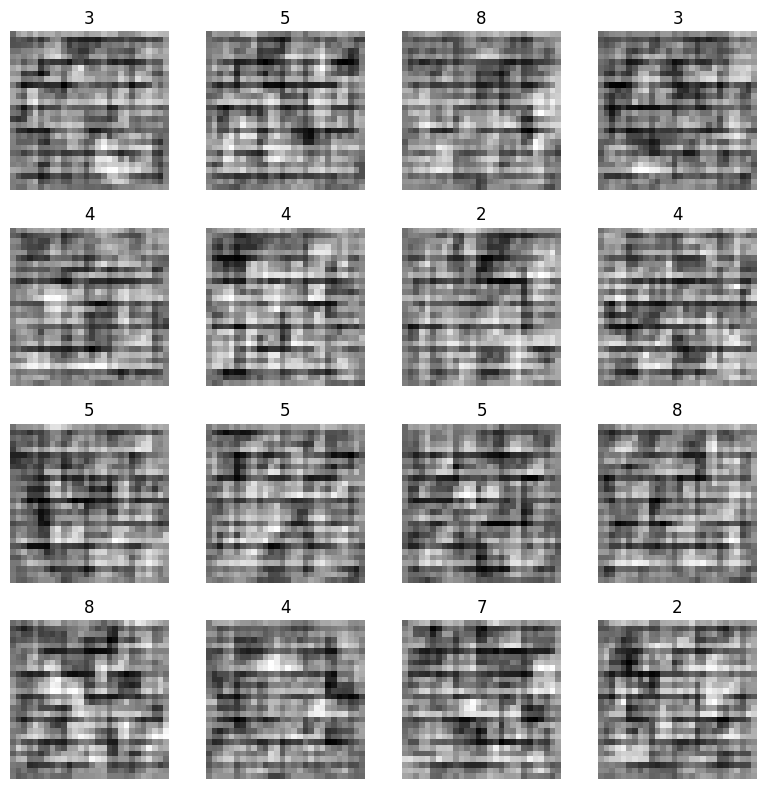

Step 1000 — D loss: -1.0797, G loss: -25.9227


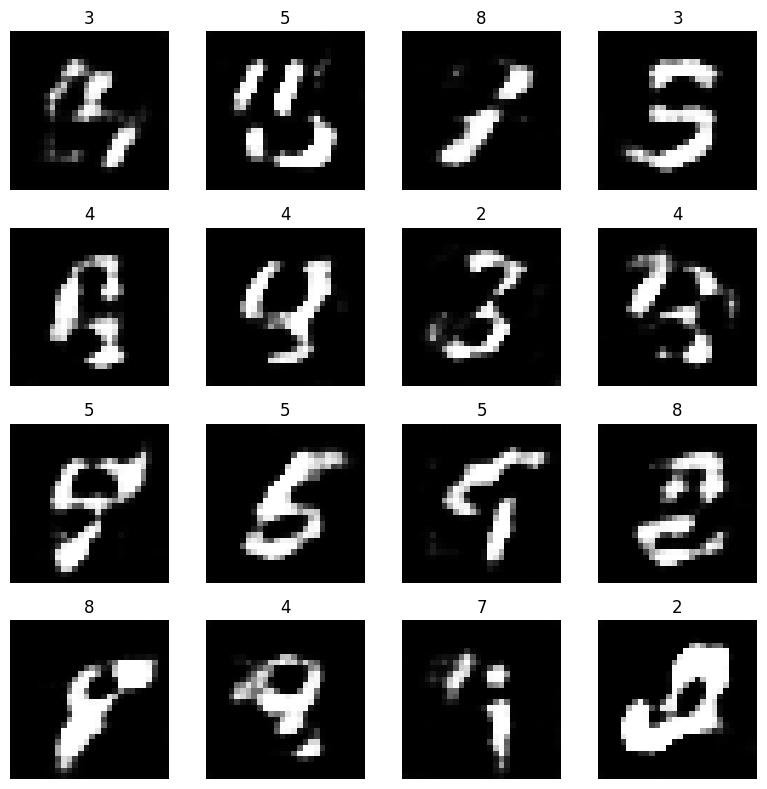

Step 2000 — D loss: -0.2757, G loss: -23.8924


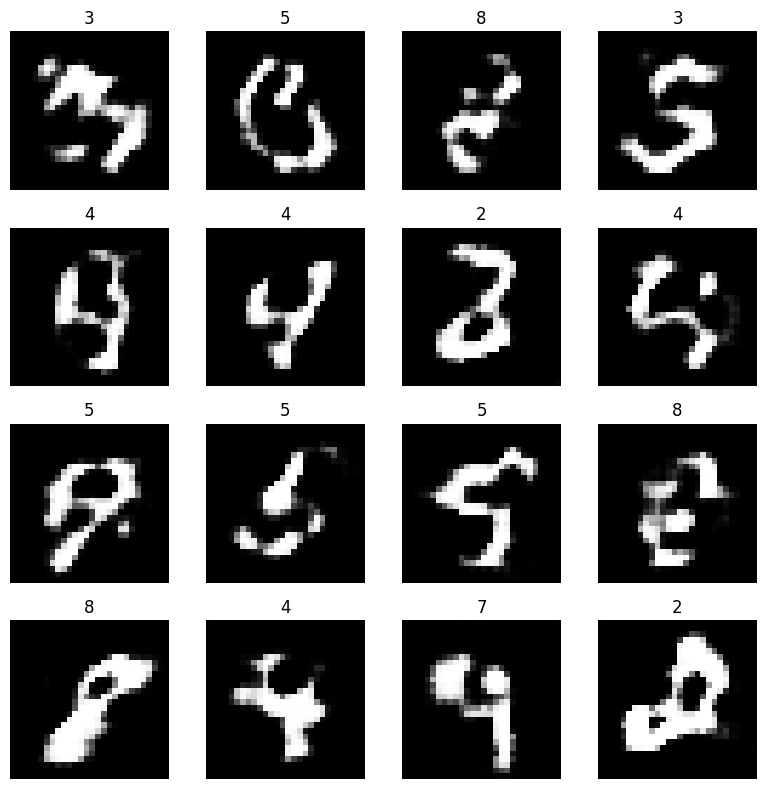

Step 3000 — D loss: -0.2972, G loss: -27.3611


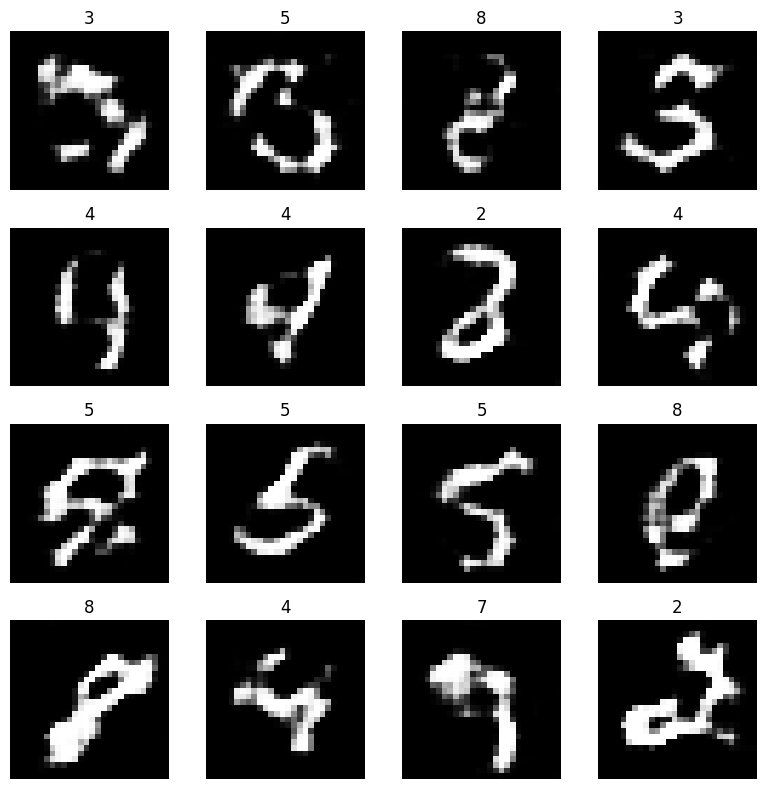

Step 4000 — D loss: -0.2759, G loss: -22.6636


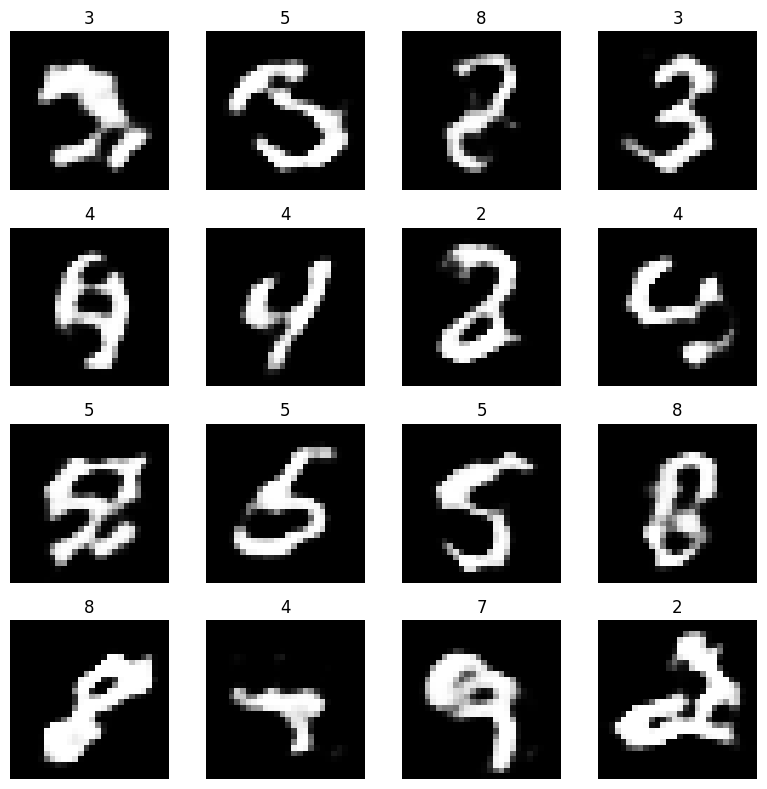

Step 5000 — D loss: -0.2234, G loss: -28.4387


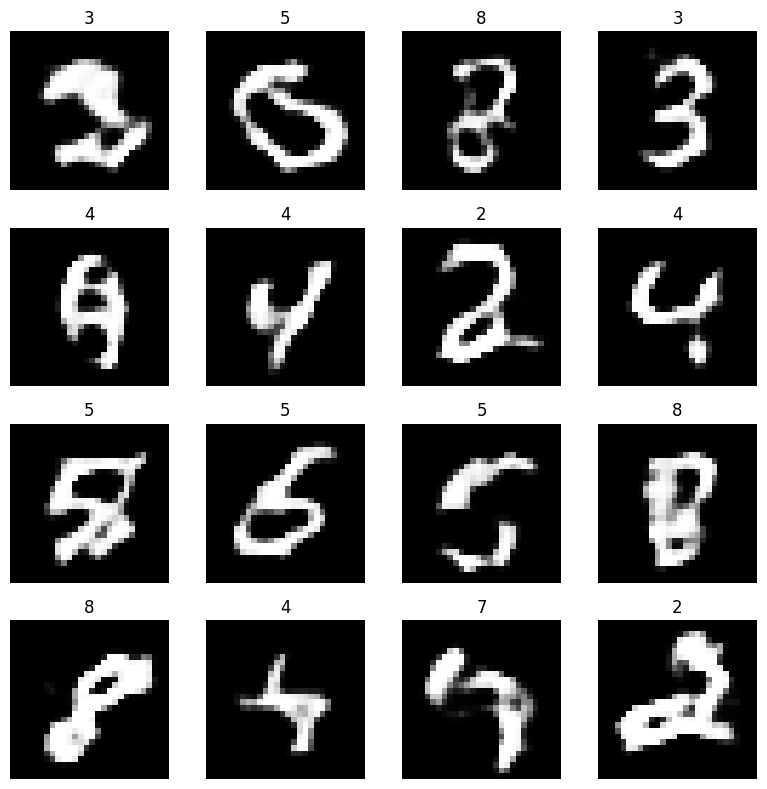

Step 6000 — D loss: -0.2551, G loss: -29.4077


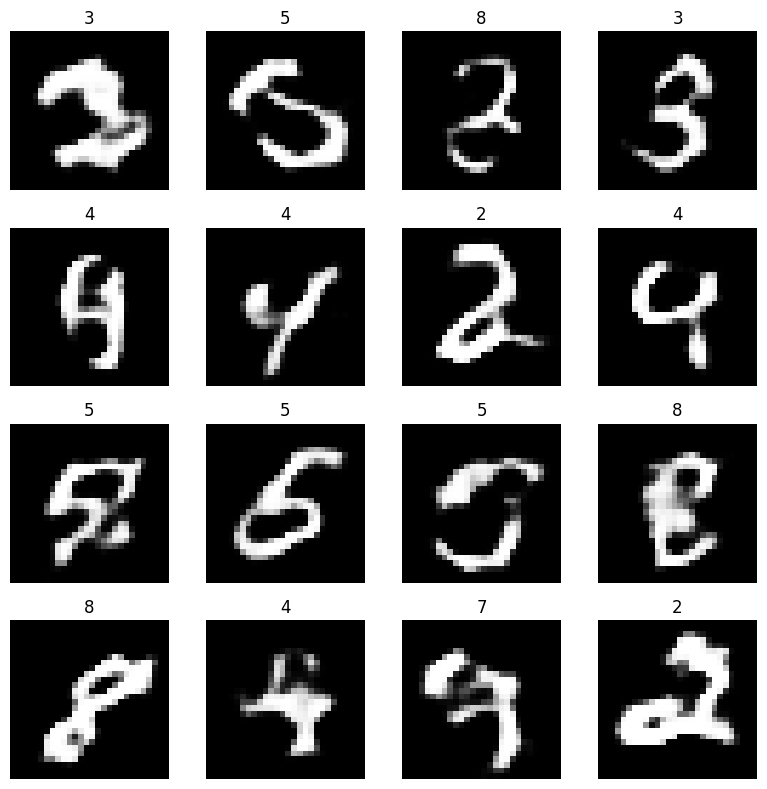

Step 7000 — D loss: -0.2579, G loss: -24.6313


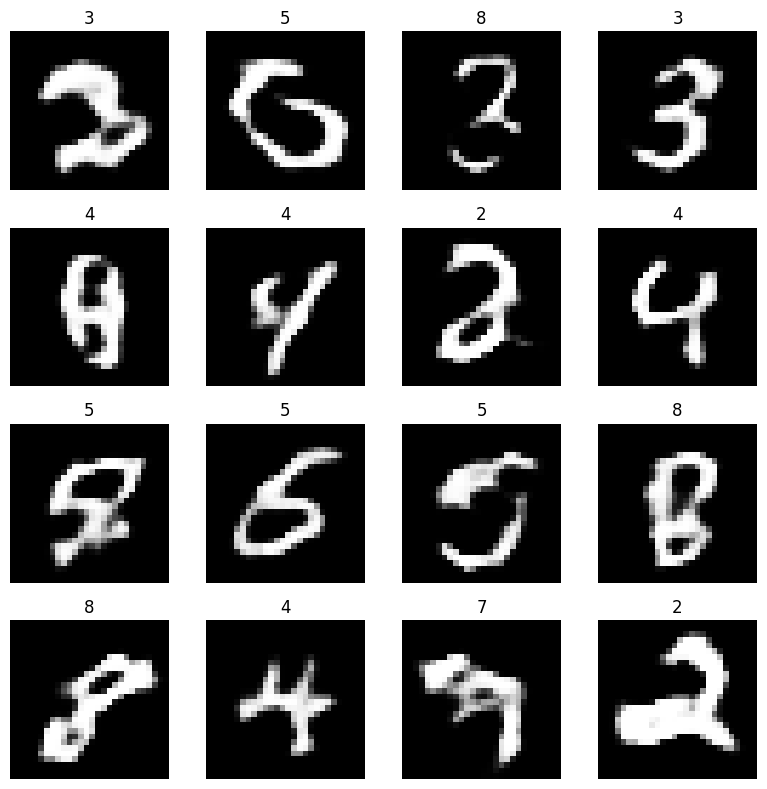

Step 8000 — D loss: -0.3563, G loss: -17.8950


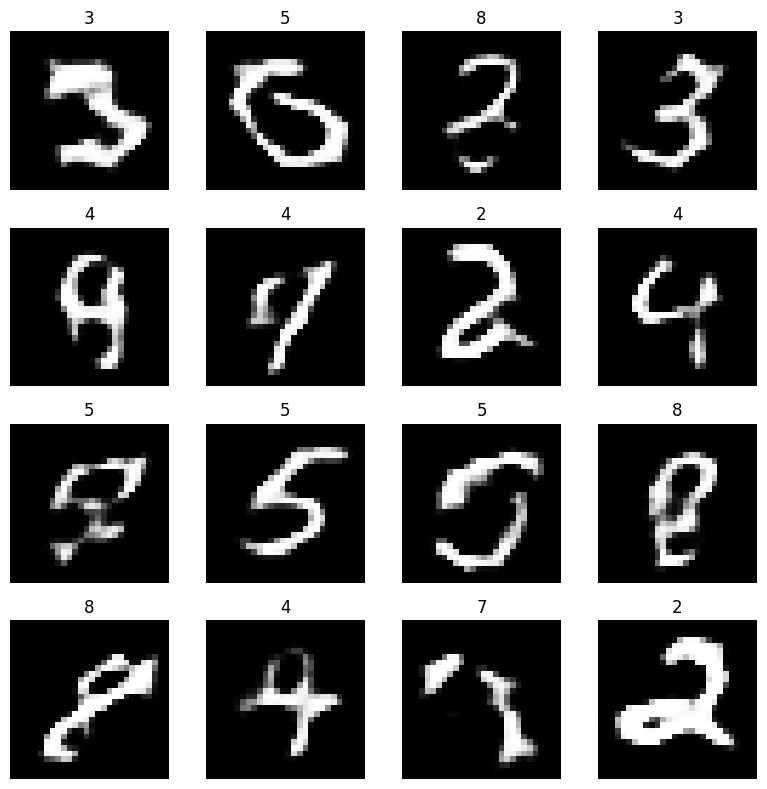

Step 9000 — D loss: -0.0938, G loss: -23.3242


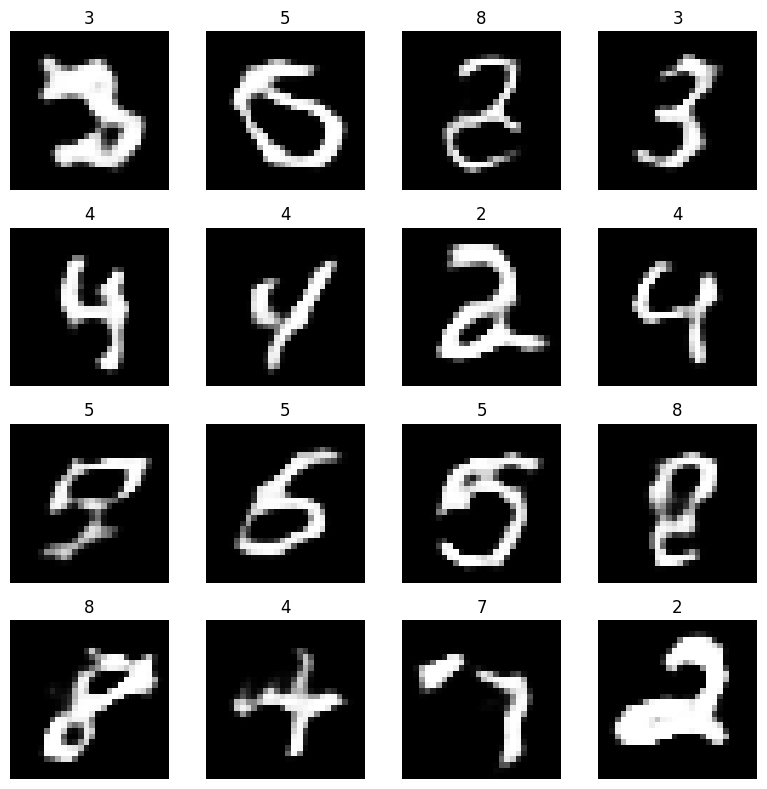

Step 10000 — D loss: -0.2396, G loss: -30.6161


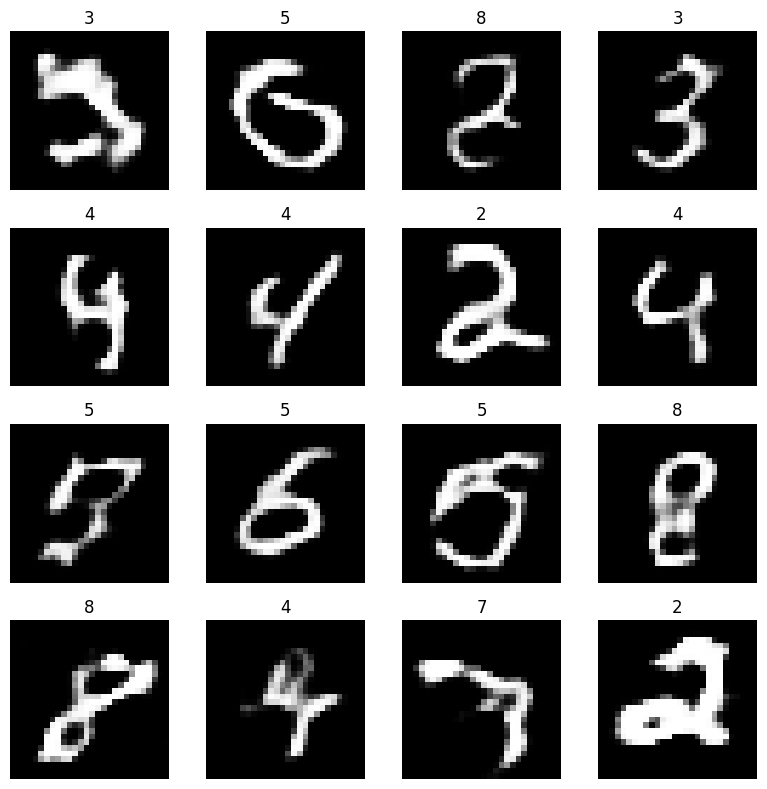

Step 11000 — D loss: 0.0885, G loss: -27.0445


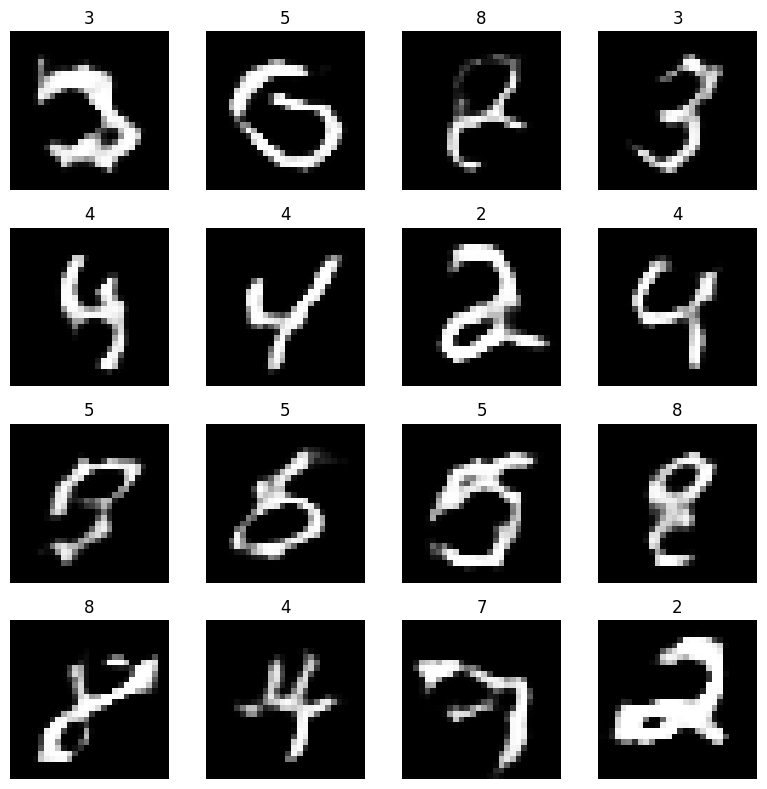

Step 12000 — D loss: -0.1120, G loss: -30.2892


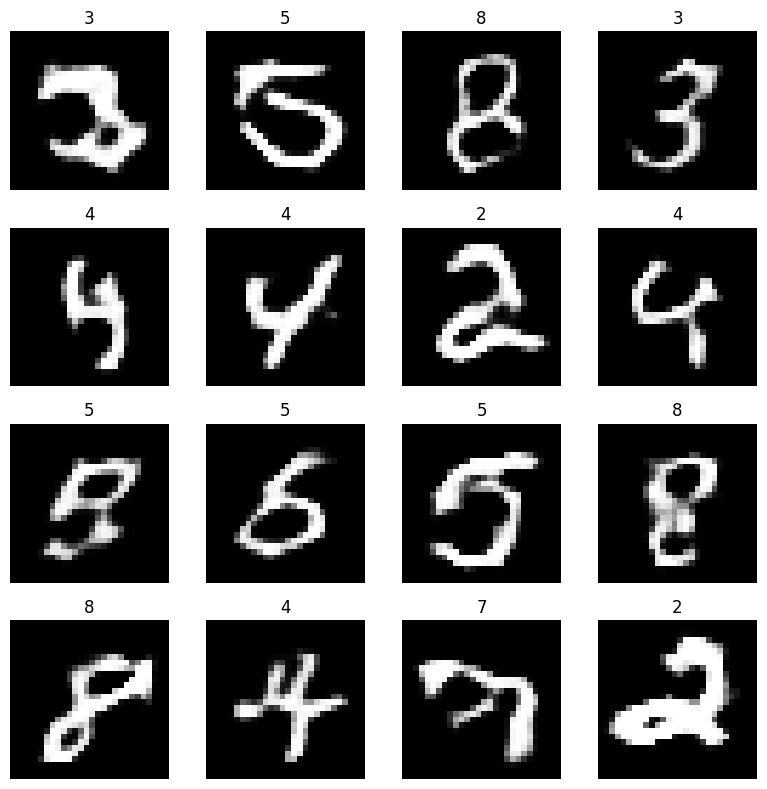

Step 13000 — D loss: -0.4915, G loss: -27.6463


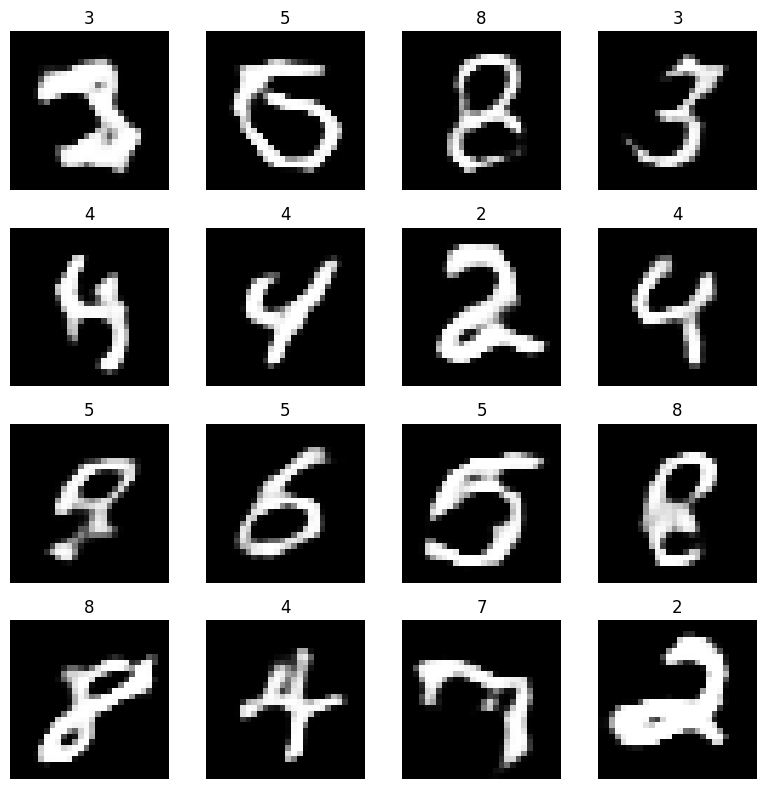

Step 14000 — D loss: -0.5255, G loss: -18.5195


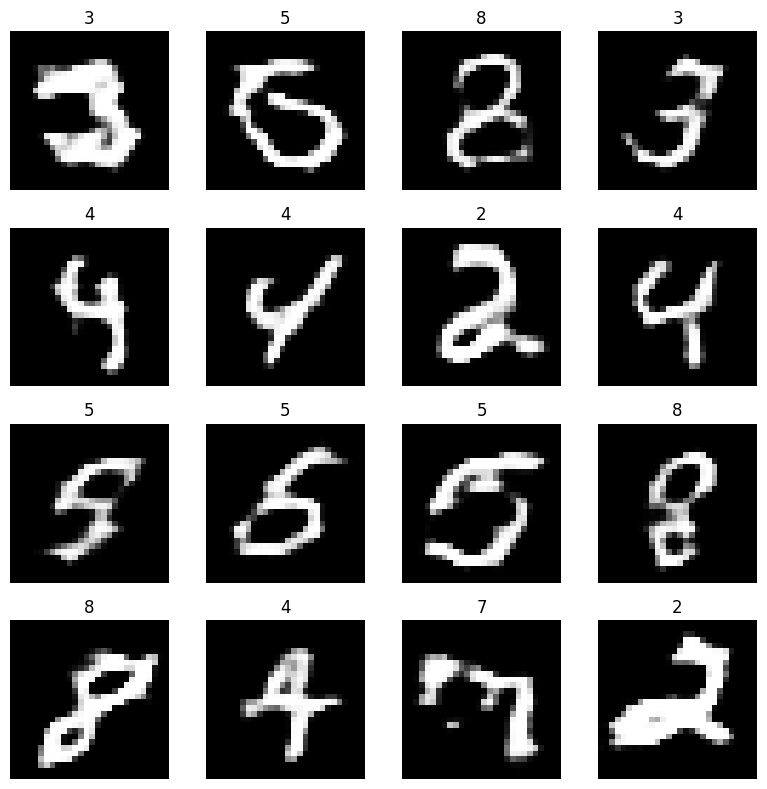

Step 15000 — D loss: 0.2711, G loss: -20.4099


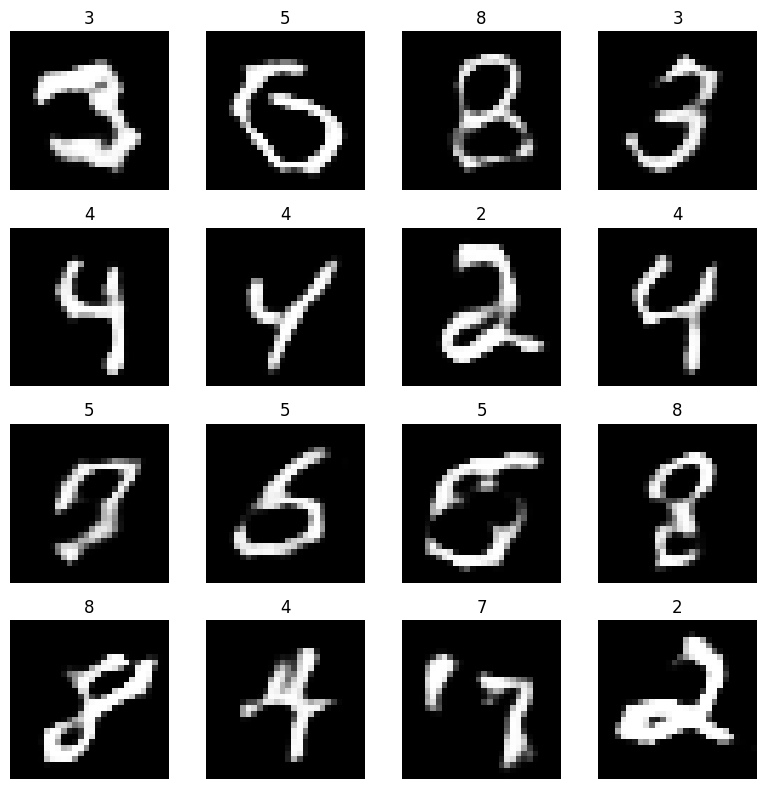

In [12]:
def plot_image(images, labels, rows, cols):
    """Plots a grid of generated images with their class labels."""
    fig = plt.figure(figsize=(8, 8))
    for i in range(rows * cols):
        img = images[i].detach().cpu().numpy().reshape(28, 28)
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(str(labels[i].item()))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    fig.tight_layout()
    plt.show()


def train_model():
    # Fixed test noise and labels
    samples_test = torch.randn(16, LATENT_DIM, device=device)
    labels_test = torch.randint(0, 10, (16, 1), device=device)

    losses = {"G": [], "D": []}

    # Create an infinite iterator over the DataLoader
    data_iter = iter(train_loader)
    
    # Get n_critic from strategy
    n_critic = loss_strategy.n_critic

    # Initialize variable
    d_loss = torch.tensor(0.0)

    for step in range(NUM_STEPS):

        # --- Train Discriminator (n_critic times) ---
        for _ in range(n_critic):
            # Get a real batch
            try:
                real_imgs, batch_labels = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                real_imgs, batch_labels = next(data_iter)

            real_imgs = real_imgs.to(device)
            batch_labels = batch_labels.unsqueeze(1).to(device)

            # Generate fake images
            noise = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
            fake_imgs = g_model(noise, batch_labels)

            # D forward pass
            optimizer_d.zero_grad()

            d_real_out = d_model(real_imgs, batch_labels)
            d_loss_real = loss_strategy.d_loss_real(d_real_out)

            d_fake_out = d_model(fake_imgs.detach(), batch_labels)
            d_loss_fake = loss_strategy.d_loss_fake(d_fake_out)

            # Gradient penalty
            gp = loss_strategy.gradient_penalty(real_imgs, fake_imgs.detach(), batch_labels)

            # Compute total D loss using strategy-specific formula
            d_loss = loss_strategy.compute_d_loss(d_loss_real, d_loss_fake, gp)
            d_loss.backward()
            optimizer_d.step()

        # --- Train Generator (1 time) ---
        optimizer_g.zero_grad()

        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_labels = torch.randint(0, 10, (BATCH_SIZE, 1), device=device)

        gen_imgs = g_model(z, gen_labels)
        g_out = d_model(gen_imgs, gen_labels)

        g_loss = loss_strategy.g_loss(g_out)
        g_loss.backward()
        optimizer_g.step()

        # --- Logging ---
        losses["G"].append(g_loss.item())
        losses["D"].append(d_loss.item())

        if step % SAVE_INTERVAL == 0:
            print(f"Step {step} — D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")
            with torch.no_grad():
                results = g_model(samples_test, labels_test)
            plot_image(results, labels_test, 4, 4)

        if LIVE_MONITOR and step % EMIT_INTERVAL == 0:
            with torch.no_grad():
                results = g_model(samples_test, labels_test)
            emit_frames(results, labels_test, step, g_loss.item(), d_loss.item())

    return losses


losses = train_model()

if LIVE_MONITOR:
    emit_done()

# 7. Loss Reporting

---

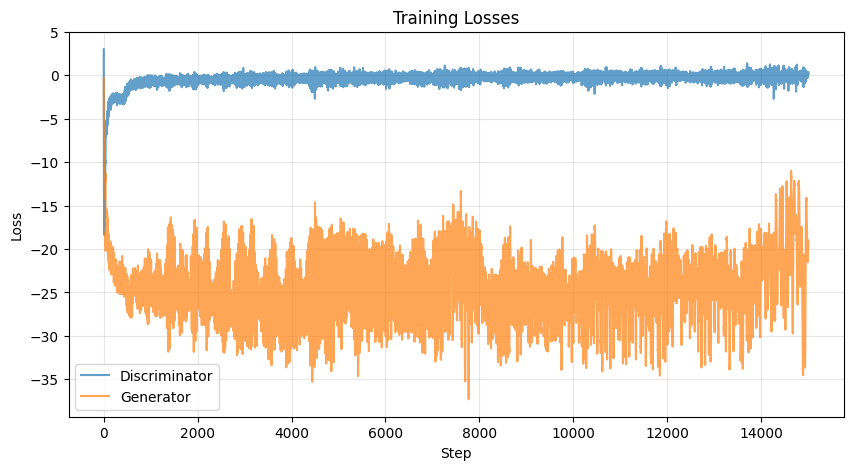

In [13]:
def plot_losses(losses):
    """Plots generator and discriminator losses over training steps."""
    plt.figure(figsize=(10, 5))
    plt.plot(losses["D"], label="Discriminator", alpha=0.7)
    plt.plot(losses["G"], label="Generator", alpha=0.7)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_losses(losses)

# 8. Per-class Grid

---

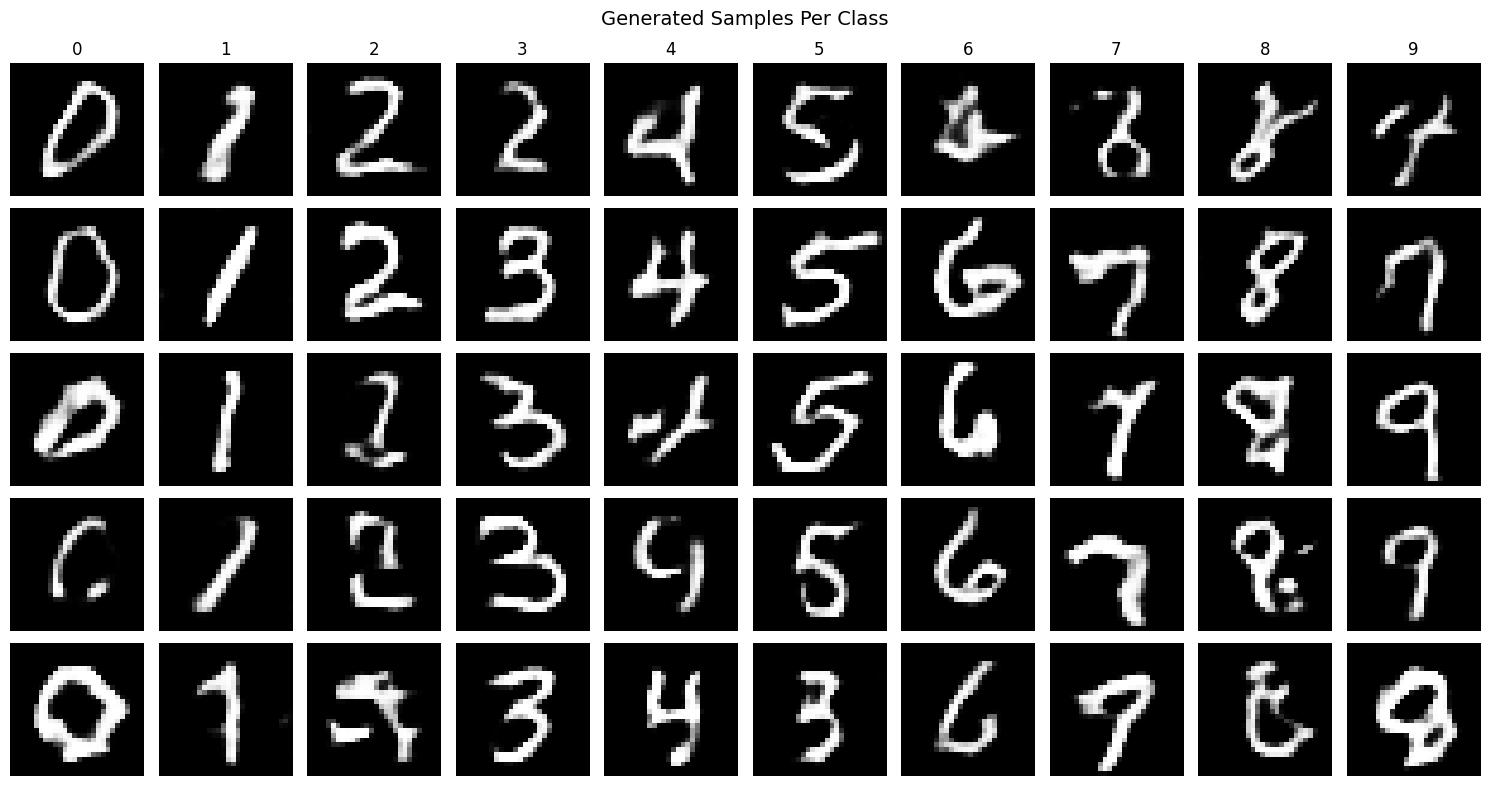

In [14]:
def plot_per_class(g_model, rows_per_class=5):
    """Generates a grid with one column per digit class (0-9)."""
    fig, axes = plt.subplots(rows_per_class, 10, figsize=(15, 8))

    for digit in range(10):
        noise = torch.randn(rows_per_class, LATENT_DIM, device=device)
        labels = torch.full((rows_per_class, 1), digit, device=device)

        with torch.no_grad():
            images = g_model(noise, labels)

        for row in range(rows_per_class):
            img = images[row].cpu().numpy().reshape(28, 28)
            axes[row, digit].imshow(img, cmap='gray')
            axes[row, digit].axis('off')

            # Column headers on the first row only
            if row == 0:
                axes[row, digit].set_title(str(digit))

    fig.suptitle("Generated Samples Per Class", fontsize=14)
    fig.tight_layout()
    plt.show()

plot_per_class(g_model)

# 9. Evaluation

---

In [15]:
def evaluate_model():
    """Computes FID and KID between real MNIST images and generated images."""

    # --- Initialize metrics ---
    # Both use Inception-v3 features internally
    # feature=2048 uses the final pooling layer (standard for FID/KID)
    fid = FrechetInceptionDistance(feature=2048).to(device)
    kid = KernelInceptionDistance(feature=2048, subset_size=100).to(device)

    # --- Prepare real images ---
    # Sample NUM_EVAL_SAMPLES random indices from the training set
    idx = np.random.randint(0, len(train_dataset), NUM_EVAL_SAMPLES)

    # Process in batches to avoid OOM
    batch_size = 256
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        batch_idx = idx[i:i + batch_size]

        # Stack real images: (batch, 1, 28, 28) in [-1, 1]
        real_batch = torch.stack([train_dataset[j][0] for j in batch_idx])

        # Inception expects 3-channel uint8 [0, 255] at minimum 299x299
        # Denormalize: [-1, 1] → [0, 1] → [0, 255]
        real_batch = ((real_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)

        # Convert grayscale to RGB by repeating the single channel 3 times
        real_batch = real_batch.repeat(1, 3, 1, 1)

        # Resize from 28x28 to 299x299 (Inception's expected input size)
        real_batch = torch.nn.functional.interpolate(
            real_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)

        # Feed real images into both metrics
        fid.update(real_batch, real=True)
        kid.update(real_batch, real=True)

    # --- Generate fake images ---
    for i in range(0, NUM_EVAL_SAMPLES, batch_size):
        current_batch = min(batch_size, NUM_EVAL_SAMPLES - i)

        noise = torch.randn(current_batch, LATENT_DIM, device=device)
        labels = torch.randint(0, 10, (current_batch, 1), device=device)

        with torch.no_grad():
            fake_batch = g_model(noise, labels)

        # Same preprocessing: denormalize → RGB → resize
        fake_batch = ((fake_batch + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_batch = fake_batch.repeat(1, 3, 1, 1)
        fake_batch = torch.nn.functional.interpolate(
            fake_batch.float(), size=(299, 299), mode='bilinear', align_corners=False
        ).to(torch.uint8).to(device)

        fid.update(fake_batch, real=False)
        kid.update(fake_batch, real=False)

    # --- Compute scores ---
    fid_score = fid.compute().item()
    kid_mean, kid_std = kid.compute()

    print(f"FID: {fid_score:.2f}")
    print(f"KID: {kid_mean.item():.4f} ± {kid_std.item():.4f}")

    return fid_score, kid_mean.item(), kid_std.item()


fid_score, kid_mean, kid_std = evaluate_model()

/home/logus/env/iscte/taap_p1/.venv_taap_p1/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


FID: 18.73
KID: 0.0144 ± 0.0036


# 10. Model Saving

---

In [16]:
def save_models():
    """Saves generator and discriminator state dicts."""
    os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

    # torch.save() serializes the state_dict (all learned parameters)
    # This is the recommended way to save in PyTorch (saving the full model object)
    torch.save(g_model.state_dict(), os.path.join(MODEL_OUTPUT_PATH, f'{G_MODEL_NAME}.pt'))
    torch.save(d_model.state_dict(), os.path.join(MODEL_OUTPUT_PATH, f'{D_MODEL_NAME}.pt'))
    print("Models saved.")

save_models()

Models saved.


# 11. Single-Image Inference

---

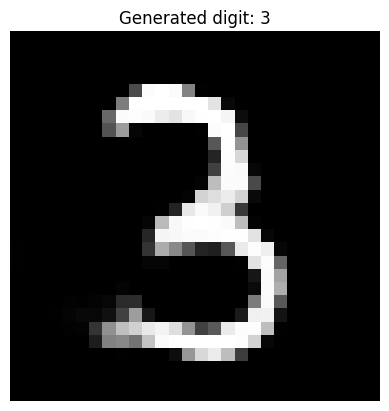

In [17]:
# Specify a digit from 0-9
digit = 3

# Generate a single image for the chosen digit
z = torch.randn(1, LATENT_DIM, device=device)
label = torch.tensor([[digit]], device=device)

# No gradient tracking needed during inference
with torch.no_grad():
    generated = g_model(z, label)

# Convert from (1, 1, 28, 28) GPU tensor to (28, 28) numpy array for plotting
img = generated[0].cpu().numpy().reshape(28, 28)
plt.imshow(img, cmap='gray')
plt.title(f"Generated digit: {digit}")
plt.axis('off')
plt.show()